In [ ]:
# Imports

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [ ]:
tf.keras.backend.set_floatx('float32')

In [ ]:
t = np.linspace(0, 25, 200)
h0 = tf.constant([[1., 0.]])
W = tf.constant([[-0.1, 1.0], [-0.2, -0.1]])

In [ ]:
W

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[-0.1,  1. ],
       [-0.2, -0.1]], dtype=float32)>

In [ ]:
h0

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1., 0.]], dtype=float32)>

In [ ]:
class Lambda(tf.keras.Model):
    def call(self, h, t, **kwargs):
        return tf.matmul(h, W)

In [ ]:
def odeint(func, z0, t, solver):
  t_diff = t[1:] - t[:-1]
  zk = z0
  tk = t[0]
  
  hist = [zk]

  for delta_t in t_diff:
    zk = solver(delta_t, zk, tk, func)
    tk = tk + delta_t
    hist.append(zk)
  return hist

In [ ]:
def euler_step(dt, zk, tk, func):
  return zk + dt * func(zk, tk)

In [ ]:
def zip_map(zipped, update_op):
    return [update_op(*elems) for elems in zipped]


def euler_update(h_list, dh_list, dt):
    return zip_map(zip(h_list, dh_list), lambda h, dh: h + tf.cast(dt, tf.float32) * dh)

def euler_step_back(dt, state, func):
    return state + func(state) * dt

In [ ]:
a = odeint(Lambda(), h0, t, euler_step)
initial_path = np.concatenate(a)

In [ ]:
hN_target = initial_path[-1]

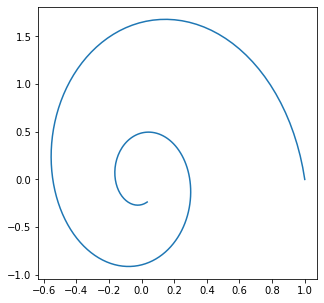

In [ ]:
plt.figure(figsize=(5, 5))
plt.plot(initial_path[:,0], initial_path[:,1])

In [ ]:
class Module(keras.Model):
    def __init__(self, nf):
        super(Module, self).__init__()        
        self.dense_2 = tf.keras.layers.Dense(nf)

    def call(self, x, t, **kwargs):
        return self.dense_2(x)

In [ ]:
class NeuralODE(keras.Model):

  def __init__(self, forcing_func, *args, **kwargs):
    super(NeuralODE, self).__init__(*args, **kwargs)
    self.func = forcing_func

  def call(self, z0, t, whole_seq = False):

    z = odeint(self.func, z0, t, euler_step)
    z = np.concatenate(z)

    if whole_seq:
      return z
    else:
      return z[-1]

  def _backward_dynamics(self, state):

    t = state[0]
    z = state[1]
    at = -state[2]

    z = tf.reshape(z, [1,2])
    at = tf.reshape(at, [1,2])

    with tf.GradientTape() as g:
      g.watch(z)
      func_eval = self.func(z, t)
    

    grad_z, grad_train = g.gradient(
        func_eval,  [z, self.func.trainable_weights],
        output_gradients=at
    )


    return [1.0, func_eval, grad_z, grad_train]

  def backwards(self, t, outputs, outputs_gradients):
    grad_weights = [tf.zeros_like(w) for w in self.func.trainable_weights]

    t0 = tf.constant([t[-1]], dtype=tf.float32)

    t_diff = t[1:] - t[:-1]

    state = [t0, outputs, outputs_gradients, grad_weights]

    for dt in t_diff[::-1]:
      dt = tf.constant(dt, dtype=tf.float32)
      out = self._backward_dynamics(state)

      state[1] = state[1] - out[1]* dt
      state[2] = state[2] - out[2]* dt
      state[3] = [start - update * dt for (start, update) in zip(state[3], out[3])]

    inputs = state[1]
    dLdInputs = state[2]
    dLdWeights = state[3:]
    return inputs, dLdInputs, dLdWeights

In [ ]:
model = Module(2)
NN = NeuralODE(model)

In [ ]:
NN(h0, t)

array([ 0.01681701, -0.01514348], dtype=float32)

In [ ]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.01)
loss_fn = tf.keras.losses.MeanSquaredError()

In [ ]:
t = np.linspace(0, 25, 200)
h0 = tf.constant([[1., 0.]])

In [ ]:
for i in range(1000):
  end = np.random.uniform(0,25)
  t = np.linspace(0, end, 200)
  a = odeint(Lambda(), h0, t, euler_step)
  initial_path = np.concatenate(a)
  hN_target = initial_path[-1]
  with tf.GradientTape() as g:
    out = NN(h0, t)
    out = tf.constant(out)
    g.watch(out)
    loss = tf.reduce_sum((hN_target - out)**2)
  if i % 10 == 0:
    print(i)
    print(loss)
  dLoss = g.gradient(loss, out)
  h0_reconstruction, dfdh0, dWeights = NN.backwards(t, out, dLoss)

  optimizer.apply_gradients(zip(dWeights[0], NN.func.trainable_weights))

0
tf.Tensor(0.8568509, shape=(), dtype=float32)
10
tf.Tensor(0.022413738, shape=(), dtype=float32)
20
tf.Tensor(0.18093312, shape=(), dtype=float32)
30
tf.Tensor(0.06213416, shape=(), dtype=float32)
40
tf.Tensor(0.09921902, shape=(), dtype=float32)
50
tf.Tensor(0.048199553, shape=(), dtype=float32)
60
tf.Tensor(2.0271554, shape=(), dtype=float32)
70
tf.Tensor(1.4403875, shape=(), dtype=float32)
80
tf.Tensor(0.4058726, shape=(), dtype=float32)
90
tf.Tensor(0.0210715, shape=(), dtype=float32)
100
tf.Tensor(0.34481704, shape=(), dtype=float32)
110
tf.Tensor(0.5846214, shape=(), dtype=float32)
120
tf.Tensor(0.0017999612, shape=(), dtype=float32)
130
tf.Tensor(0.17740643, shape=(), dtype=float32)
140
tf.Tensor(0.09860051, shape=(), dtype=float32)
150
tf.Tensor(0.15026468, shape=(), dtype=float32)
160
tf.Tensor(0.67857254, shape=(), dtype=float32)
170
tf.Tensor(0.0316522, shape=(), dtype=float32)
180
tf.Tensor(0.47210926, shape=(), dtype=float32)
190
tf.Tensor(0.16073483, shape=(), dtype=flo

In [ ]:
t = np.linspace(0, 25, 200)
h0 = tf.constant([[1., 0.]])
a = NN(h0, t, True)

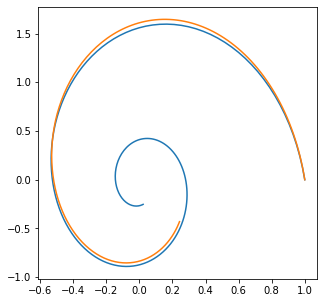

In [ ]:
plt.figure(figsize=(5, 5))
plt.plot(a[:,0], a[:,1])
plt.plot(initial_path[:,0], initial_path[:,1])

In [ ]:
NN.trainable_weights

[<tf.Variable 'neural_ode/module/dense/kernel:0' shape=(2, 2) dtype=float32, numpy=
 array([[-0.8110299 ,  0.19058914],
        [-0.5473115 , -1.1721035 ]], dtype=float32)>,
 <tf.Variable 'neural_ode/module/dense/bias:0' shape=(2,) dtype=float32, numpy=array([-0.01637637,  0.11210658], dtype=float32)>]